# pyfox example


In [1]:
from IPython.display import HTML

hide_me = ''
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [2]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import yaml

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import string
import datetime
import pandas as pd
import copy
import btmm_process

# Often there are annoying "divide by zero" warning messages. They are not useful so we ignore them.
import warnings
warnings.filterwarnings("ignore")

## Format plots

In [3]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']
ms_list = ['v', '*', 's', 'o']

alphabet = list(string.ascii_lowercase)

### Directories

- The example notebook assumes that the directory structure is identical to the one found on github.

In [6]:
# DTS data
dir_dts_data = os.getcwd()
dir_data_cal = os.path.join(dir_dts_data, 'calibrated')
dir_data_raw = os.path.join(dir_dts_data,  'raw_netcdf')
dir_data_final = os.path.join(dir_dts_data, 'final')

# Met data
dir_ref_data = os.path.join(dir_pre, 'reference_temperature')

# Figures
dir_print = os.path.join(dir_pre, 'figures')

/Users/karllapo/Desktop/software/python/packages/btmm_process/example


#### Load the configuration file

We need to refer to the location library later for mapping the reference sections and evaluating the calibration.

In [8]:
os.chdir(dir_dts_data)

# Read location library
cfg = 'outer_array_190715.v1_190920.yml'
cfg = yaml.load(cfg)
with open(cfg, 'r') as stream:
    cfg = yaml.load(stream)

# For ease of reference the location library is stored in its own dictionary.
phys_locs = cfg['location_library']
# Extract out the reference baths from the mapping library.
#Reference baths MUST be labeled with `calibration` as the `loc_type`.
bath_names = [pl for pl in phys_locs
              if phys_locs[pl]['loc_type'] == 'calibration']

# Raw data

This step can be run after converting the archived data into `raw_netcdfs`, e.g. within the pyfox config file

```python
archive_read_flag = True
```

For the example this step of pyfox has already been completed for saving space. Instead we provide a sample of a white pvc fiber optic cable in a rectangular configuration for a five minute interval at midnight. This fiber was observed as part of a set of nested fibers. It passes through 2 reference sections, cooled and heated blocks of copper, at both the very beginning and end of the fiber optic array. These reference section copper blocks give two known temperatures at four points. They were monitored using embedded pt100s. These temperatures and reference sections allow the single-ended calibration for the FODS array.

### Data check - file contents

First, let us see what is included in the netcdfs without any processing. The original data files in the archive contain DTS data from fibers arrayed in nested rectangles around a grass field. As this includes several different cores that complicate data analysis, we instead select just the first fiber which is found between `LAF = (0m, 655m)`. We will use this data for the rest of the notebook. 

In [5]:
os.chdir(dir_data_raw)
ds = xr.open_dataset('raw_channel 1_20190722-0000.nc')

smpl_data = ds.sel(LAF=slice(ds.LAF.min(), 655))
print(smpl_data)

<xarray.Dataset>
Dimensions:  (LAF: 11498, time: 170)
Coordinates:
  * LAF      (LAF) float64 -222.9 -222.6 -222.4 ... 2.699e+03 2.699e+03 2.7e+03
  * time     (time) datetime64[ns] 2019-07-22T00:00:03 ... 2019-07-22T00:14:57
Data variables:
    Ps       (time, LAF) float64 dask.array<shape=(170, 11498), chunksize=(57, 11498)>
    Pas      (time, LAF) float64 dask.array<shape=(170, 11498), chunksize=(57, 11498)>
    temp     (time, LAF) float64 dask.array<shape=(170, 11498), chunksize=(57, 11498)>
Attributes:
    LAF_beg:  -222.866
    LAF_end:  2699.663
    dLAF:     0.254


The netcdf contains the stokes and anti-stokes intensities (`Ps` and `Pas`) and the instrument reported temperature (`temp`). All three data variables are matrices with dimensions labeled by length along fiber (`LAF`) and time (`time`). Other attributes, such as the total fiber length and the spatial resolution are stored as well. The xarray dataset is the container that we use for all further operations in pyfox.

### Data check - instrument reported temperatures

After this step the data quality and mapping needs to be checked. First we look at the instrument reported temperature, stored within the  field in the netcdf.

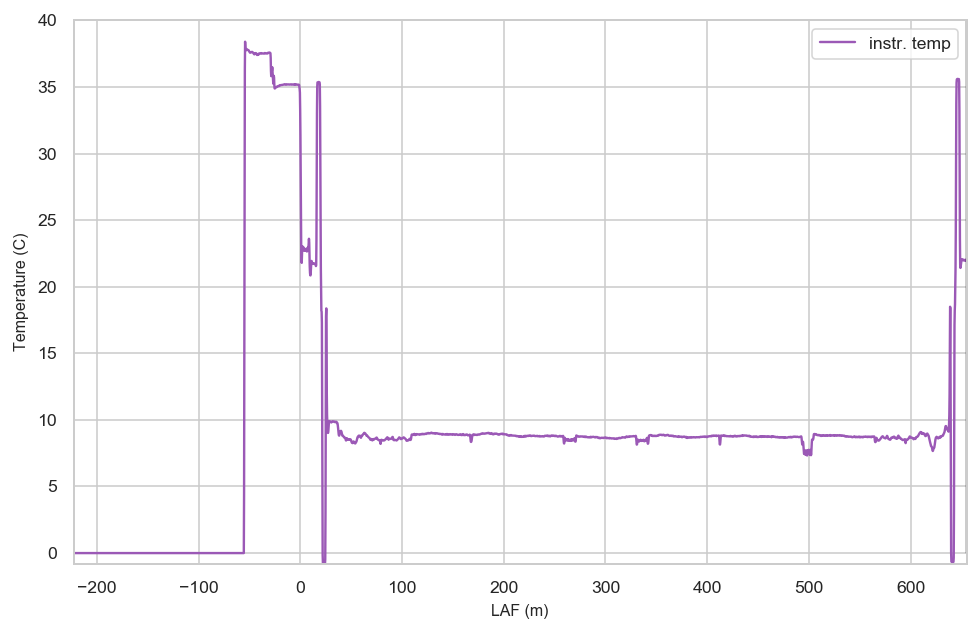

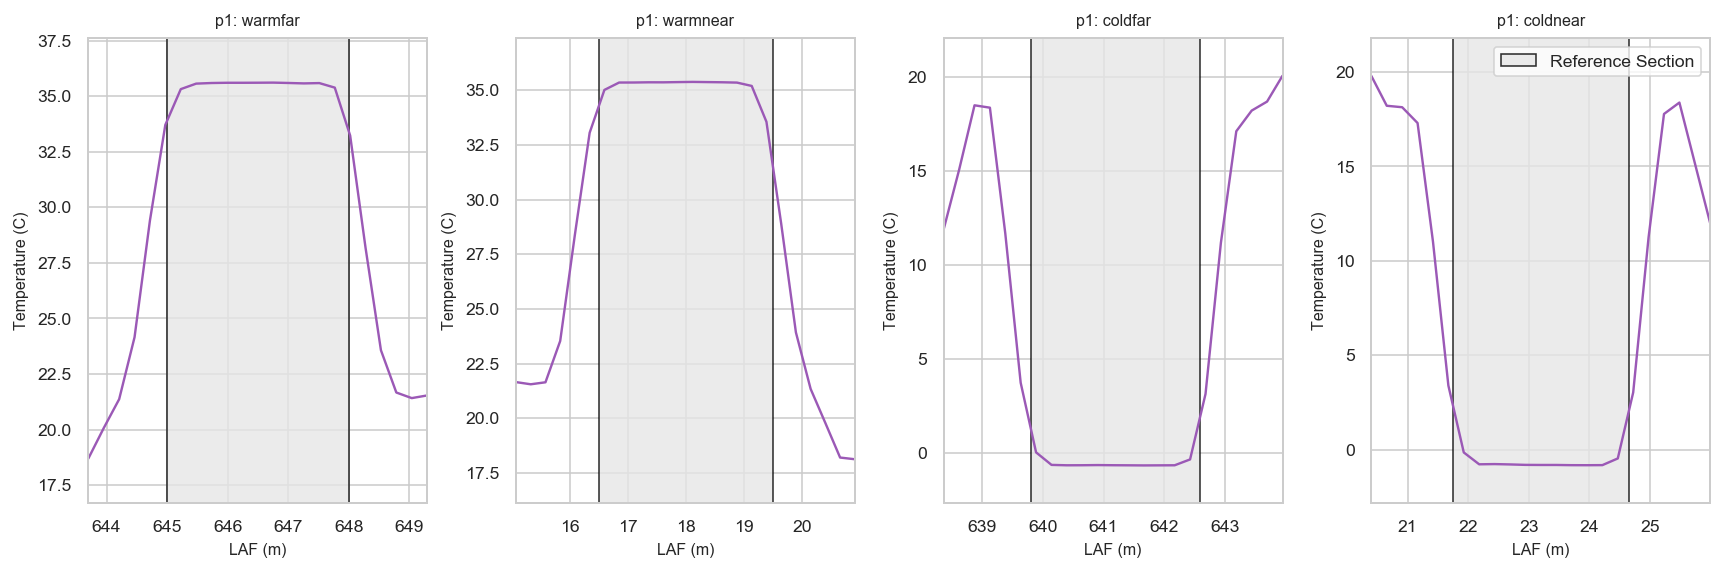

In [25]:
# Time average the data
smpl_data_mean = smpl_data.mean(dim='time')

# Let's look at the entire fiber
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(smpl_data_mean.LAF,
        smpl_data_mean.temp, label='instr. temp')

ax.set_xlim(0, smpl_data_mean.LAF.max())

ax.autoscale(enable=True, tight=True)
ax.legend(loc='best')
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('LAF (m)')
ax.plot([655, 655], [0, 40], 'k-')

# Reference baths
fig, axes = plt.subplots(1, len(bath_names), figsize=(12, 4))
c = 'p1'
for bn_num, bn in enumerate(bath_names):
    ax = axes[bn_num]
    ax.set_title(c + ': ' + bn)

    bath_start = phys_locs[bn]['LAF'][c][0]
    bath_end = phys_locs[bn]['LAF'][c][1]
    
    ds_bath = smpl_data_mean.sel(LAF=slice(bath_start - 1.5,
                                           bath_end + 1.5))
    
    # Fill in the "current" bath locations
    ax.fill_between([bath_start, bath_end],
                    ds_bath.temp.min() - 2, ds_bath.temp.max() + 2,
                    edgecolor='k', facecolor='0.9', alpha=0.8, label='Reference Section')

    # The instrument reported temperature data
    ax.plot(ds_bath.LAF, ds_bath.temp)

    ax.autoscale(enable=True, tight=True)
    ax.set_ylabel('Temperature (C)')
    ax.set_xlabel('LAF (m)')

ax.legend()
fig.tight_layout()

The bath locations we provided to the location library include the transition between the ambient and reference section temperature. Checking the reference sections is a necessary step in order to correct these types of issues. 

### Data check - $log(\frac{P_s}{P_{as}})$

The log ratio of the stokes/anti-stokes intensities are necessary for important diagnostics of the fiber. Here we walk through several basic checks. First, we look at the mean power and the standard deviation of the power across the whole fiber.

In [30]:
power = np.log(smpl_data.Ps / smpl_data.Pas).sel(LAF=slice(0, smpl_data.LAF.max()))
power_timeavg = power.mean(dim='time')
power_timestd = power.std(dim='time')

(0, <xarray.DataArray 'LAF' ()>
 array(654.884))

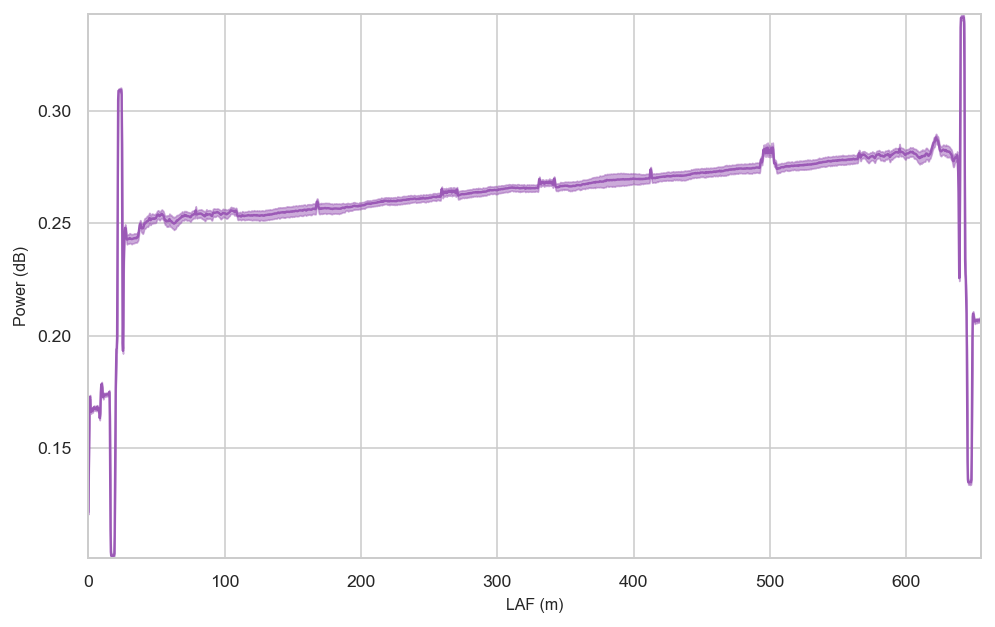

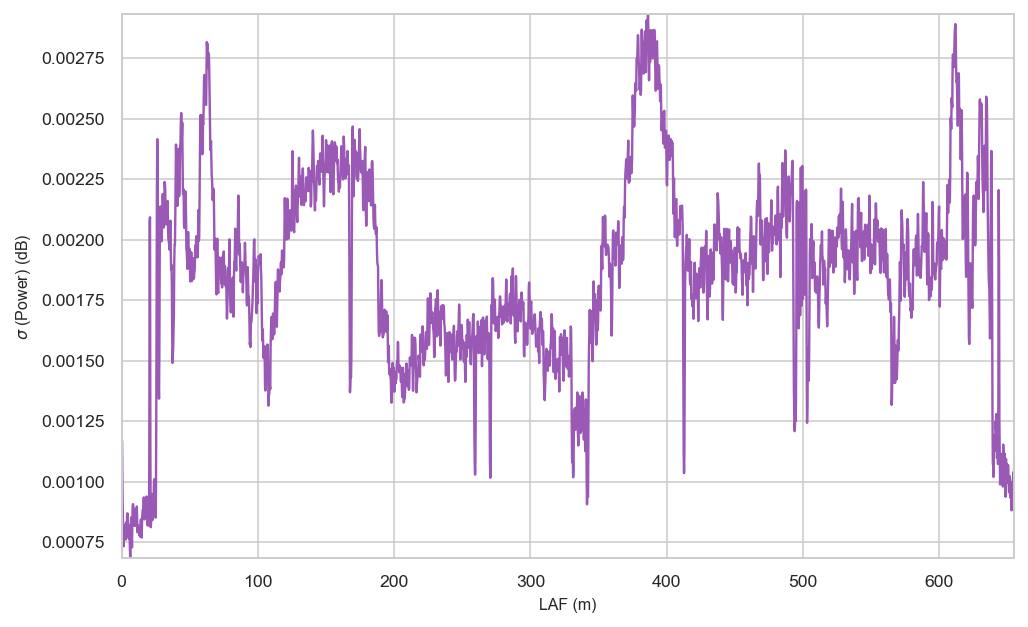

In [36]:
# Entire fiber mean power with shaded uncertainty range
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(power.LAF, power_timeavg.values)
ax.fill_between(power.LAF,
                power_timeavg.values - power_timestd.values,
                power_timeavg.values + power_timestd,
                color=flatui[0], alpha=0.5)
ax.autoscale(axis='y', tight=True)
ax.set_xlim(0, power.LAF.max())

ax.set_ylabel('Power (dB)')
ax.set_xlabel('LAF (m)')

# Entire fiber time-averaged standard deviation of power
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(power.LAF, power_timestd.values)

ax.set_ylabel(r'$\sigma$ (Power) (dB)')
ax.set_xlabel('LAF (m)')
ax.autoscale(axis='y', tight=True)
ax.set_xlim(0, power.LAF.max())

The large changes in the power's standard deviation highlight regions of fast changing temperature and artifacts, such as from where the fiber contacts the holders. Second, we look at the power anomaly within the reference sections. Within the reference sections the power anomaly should be flat and very near to zero.

NameError: name 'bath_locs_new' is not defined

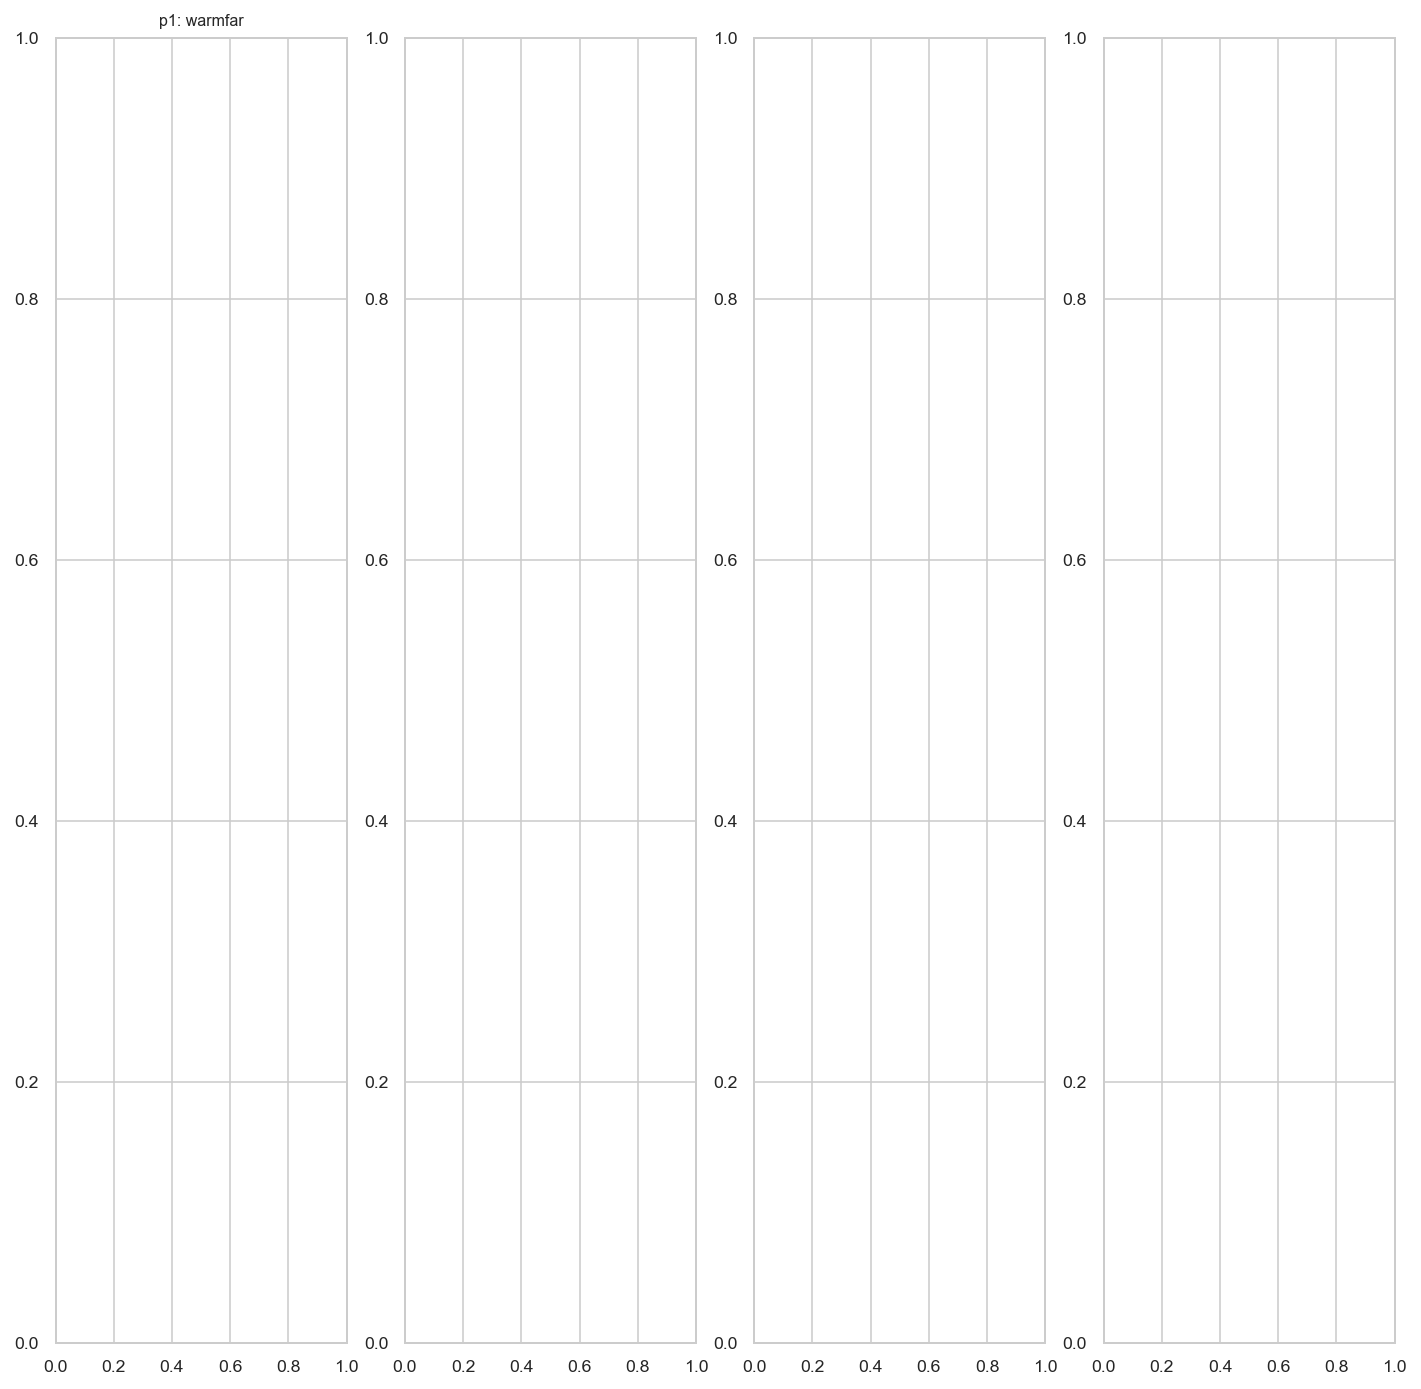

In [37]:
# ------------------------
# Mean of power
fig, axes = plt.subplots(1, len(bath_names), figsize=(12, 12))

c = 'p1'
for bn_num, bn in enumerate(bath_names):
    ax = axes[bn_num]
    ax.xaxis.grid(True, which='minor')
    ax.set_title(c + ': ' + bn)

    bath_start = phys_locs[bn]['LAF'][c][0]
    bath_end = phys_locs[bn]['LAF'][c][1]
    mean_power = power.sel(LAF=slice(bath_start, bath_end)).mean(dim='LAF').mean(dim='time').values

    # Fill in the "current" bath locations
    ax.fill_between([bath_start, bath_end], -20, 60, edgecolor='k', facecolor='0.9', alpha=0.8, label='New Baths')

    # Power perturbation
    ax.plot(dsraw.LAF, power_timeavg.values - mean_power)

    # The previous iteration of bath locations for comparison
    ax.plot([bath_locs_prev[bn]['LAF'][c][0], bath_locs_prev[bn]['LAF'][c][0]], [-20, 60], 'k--', label='Old Baths')
    ax.plot([bath_locs_prev[bn]['LAF'][c][1], bath_locs_prev[bn]['LAF'][c][1]], [-20, 60], 'k--')

    ax.set_xlim(bath_start - 1.5, bath_end + 1.5)
    ax.set_ylim(-0.005, 0.005)

    ax.set_ylabel(r'$log(\frac{Ps}{Pas}) - \overline{log(\frac{Ps}{Pas})}$')
    ax.set_xlabel('LAF (m)')
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
ax.legend(loc='upper right', frameon=True)
fig.tight_layout()


Channel 1 = South Simba

Channel 2 = Rim

# Data Overview

## Instrument Reported Temperature

Text(0.5, 1.0, 'Far baths ($LAFs > LAF_{break}$)')

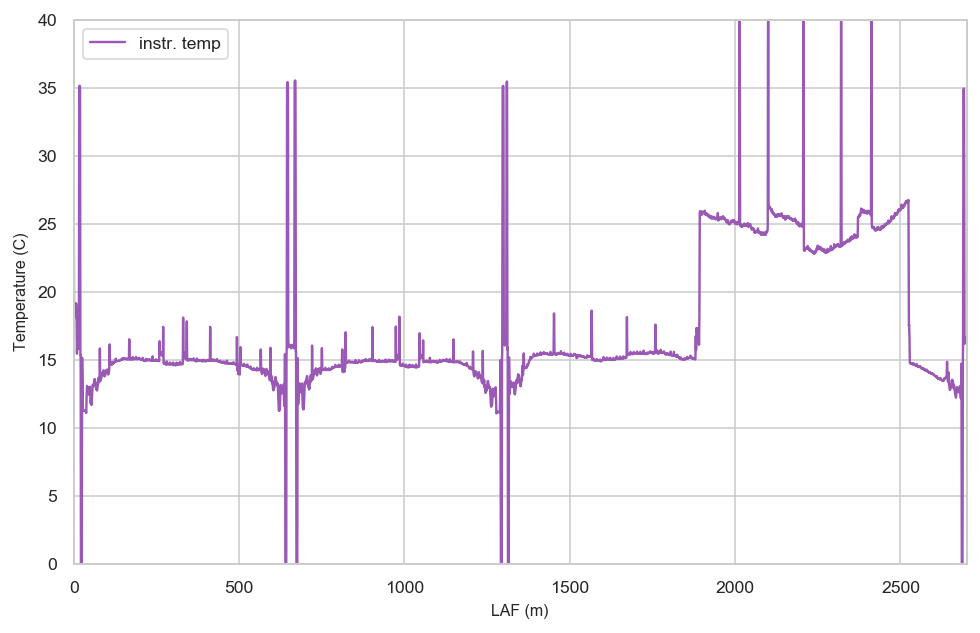

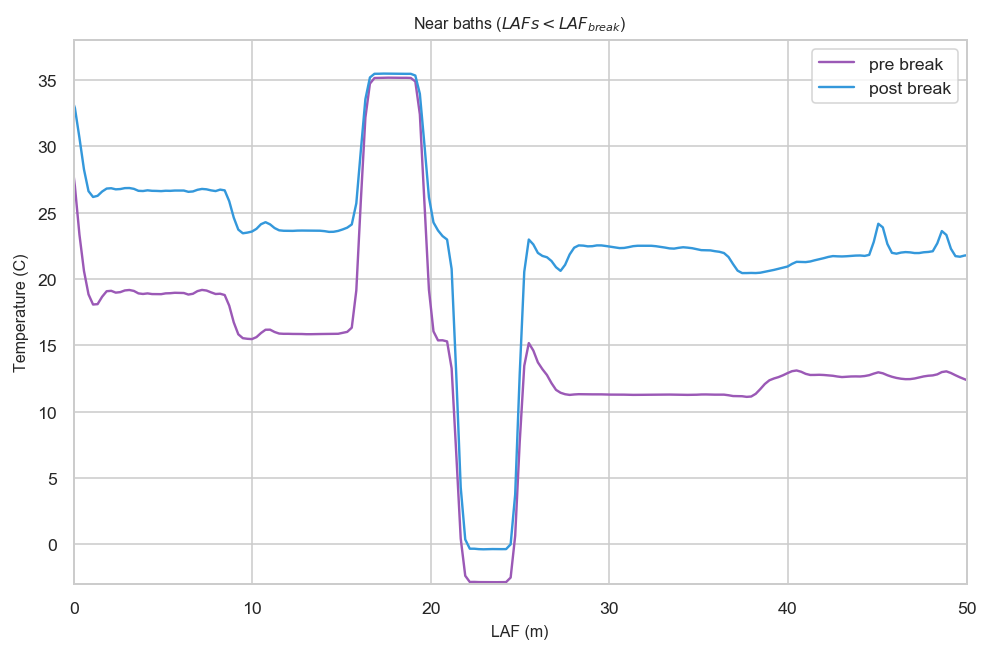

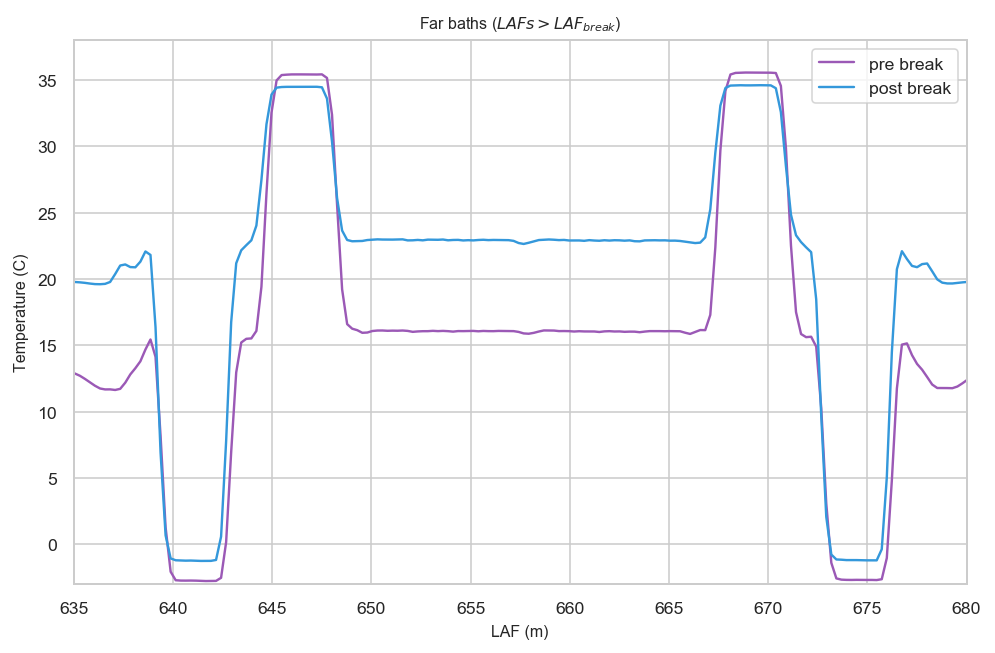

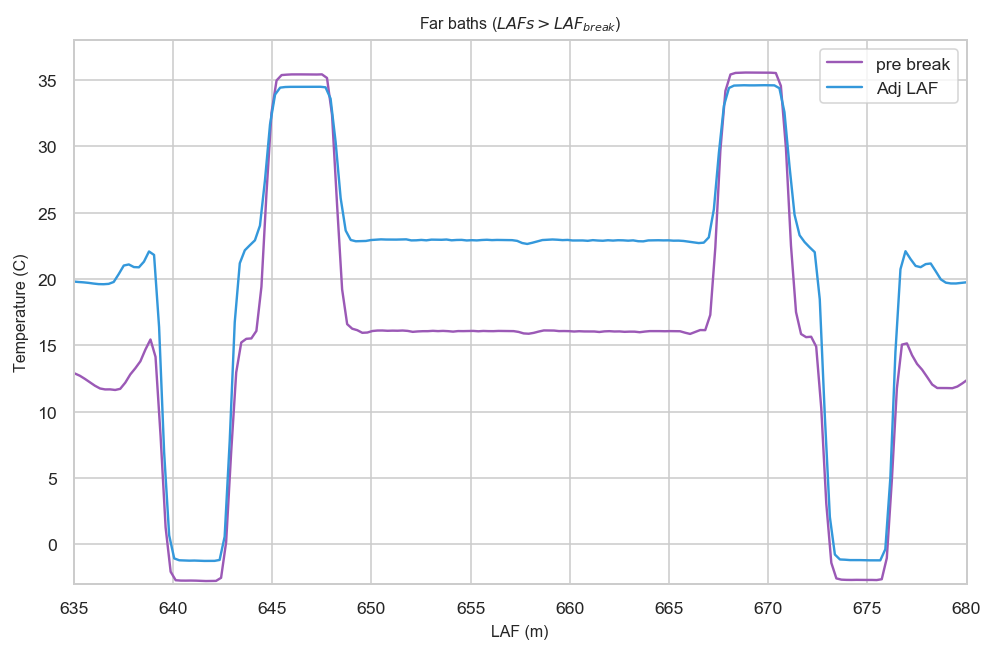

In [6]:
# Let's look at the entire fiber
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(dsraw.LAF, dsraw.temp.mean(dim='time').values, label='instr. temp')

ymin = 0
ymax = 40
ax.set_ylim(ymin, ymax)
ax.set_xlim(0, dsraw.LAF.max())

ax.legend(loc='best')
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('LAF (m)')

os.chdir(dir_print)
# fig.savefig(exp_name + '.raw.ql.pdf')

# Pre and post break - near baths
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(dsraw.LAF, dsraw.temp.mean(dim='time').values, label='pre break')
ax.plot(dsraw_postbreak.LAF, dsraw_postbreak.temp.mean(dim='time'), label='post break')

ax.legend()
ymin = -3
ymax = 38
ax.set_ylim(ymin, ymax)
ax.set_xlim(0, 50)
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('LAF (m)')
ax.set_title('Near baths ($LAFs < LAF_{break}$)')


# Pre and post break - far baths
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(dsraw.LAF, dsraw.temp.mean(dim='time').values, label='pre break')
ax.plot(dsraw_postbreak.LAF, dsraw_postbreak.temp.mean(dim='time'), label='post break')

ax.legend()
ymin = -3
ymax = 38
ax.set_ylim(ymin, ymax)
ax.set_xlim(635, 680)
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('LAF (m)')
ax.set_title('Far baths ($LAFs > LAF_{break}$)')

# Pre and post break - far baths with adjusted LAFs
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(dsraw.LAF, dsraw.temp.mean(dim='time'), label='pre break')
ax.plot(dsraw_postbreak.LAF + 0.18, dsraw_postbreak.temp.mean(dim='time'), label='Adj LAF')

ax.legend()
ymin = -3
ymax = 38
ax.set_ylim(ymin, ymax)
ax.set_xlim(635, 680)
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('LAF (m)')
ax.set_title('Far baths ($LAFs > LAF_{break}$)')

The break (July 27th) and subsequent splice on July 29th shortens the array by about 18cm. We will need to adjust all non-near bath locations by that amount as the break occurred right next to the trailer. 

## $log(\frac{P_s}{P_{as}})$

In [7]:
power = np.log(dsraw.Ps / dsraw.Pas)
power_timeavg = power.mean(dim='time')
power_timestd = power.std(dim='time')

(0, <xarray.DataArray 'LAF' ()>
 array(2699.66))

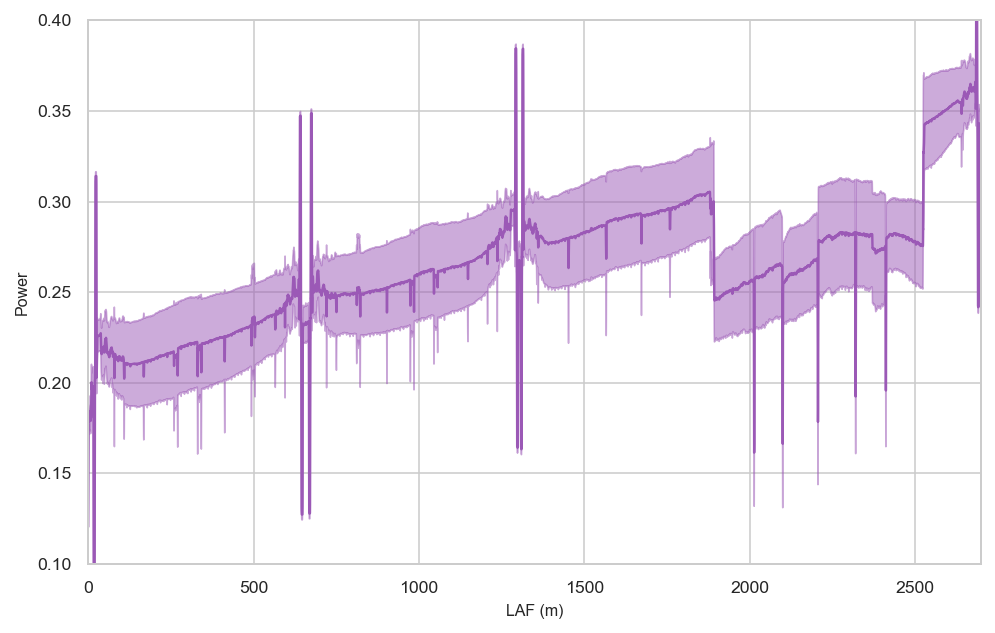

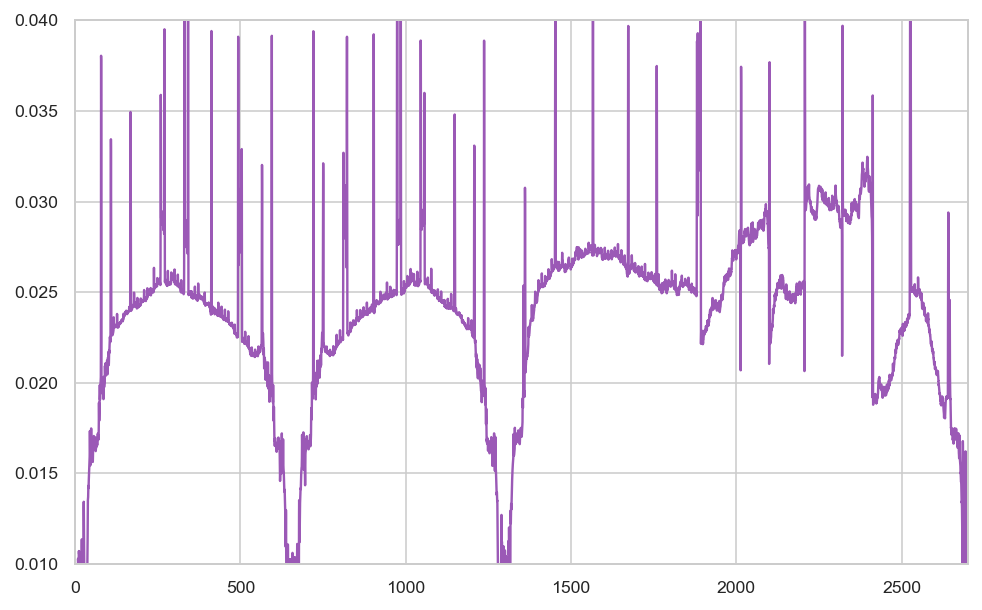

In [8]:
# Let's look at the entire fiber
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(dsraw.LAF, power_timeavg.values)
ax.fill_between(power.LAF, power_timeavg.values - power_timestd.values, power_timeavg.values + power_timestd, color=flatui[0], alpha=0.5)
ax.set_ylim(0.1, 0.4)
ax.set_xlim(0, dsraw.LAF.max())

ax.set_ylabel('Power')
ax.set_xlabel('LAF (m)')

# LAF of std
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(power.LAF, power_timestd.values)

ax.set_ylim(0.01, 0.04)
ax.set_xlim(0, dsraw.LAF.max())

# Baths

## Refining the bath location

This is an iterative process and often involves several changes over time. I try to keep track of those as I go.

### Old bath locations

Keep these values for future reference. These are the values that were found when using an ice pack. They were found by eye and should not be the final values used.

In [9]:
# Read location library
phys_locs_file = '/Users/karllapo/Desktop/proj/DarkMix_Voitsumra/love_dts/OuterArray_physloc.yml'
phys_locs = yaml.load(phys_locs_file)
with open(phys_locs_file, 'r') as stream:
    phys_locs = yaml.load(stream)
phys_locs = phys_locs['location_library']

# Store the old (and incorrect) bath locations - v1
bath_locs_prev = {'warmnear': {'LAF': {'p1': [16.5, 19.5], 'p2': [667.75, 670.75], 'ss': [1308.6, 1310.6]}},
                 'warmfar': {'LAF': {'p1': [645.0, 648.0], 'p2': [1296.75, 1299.75], 'ss': [2690.0, 2692.5]}},
                 'coldnear': {'LAF': {'p1': [21.75, 24.65], 'p2': [673.25, 676.25], 'ss': [1313.2, 1315.5]}},
                 'coldfar': {'LAF': {'p1': [639.8, 642.6], 'p2': [1291.5, 1294.25], 'ss': [2685.4, 2687.7]}}
                }

# Store the old (and incorrect) bath locations - v2
bath_locs_new = {'warmnear': {'LAF': {'p1': [17, 18.8], 'p2': [668.35, 670.25], 'ss': [1309.25, 1310.2]}},
                 'warmfar': {'LAF': {'p1': [645.7, 647.5], 'p2': [1297.3, 1299.], 'ss': [2690.8, 2691.7]}},
                 'coldnear': {'LAF': {'p1': [22.2, 24.2], 'p2': [673.7, 675.5], 'ss': [1313.6, 1315.]}},
                 'coldfar': {'LAF': {'p1': [673.8, 675.5], 'p2': [1291.9, 1293.7], 'ss': [2685.9, 2686.9]}}
                }


bathnames = ['warmnear', 'warmfar', 'coldnear', 'coldfar']
cores = ['p1', 'p2', 'ss']

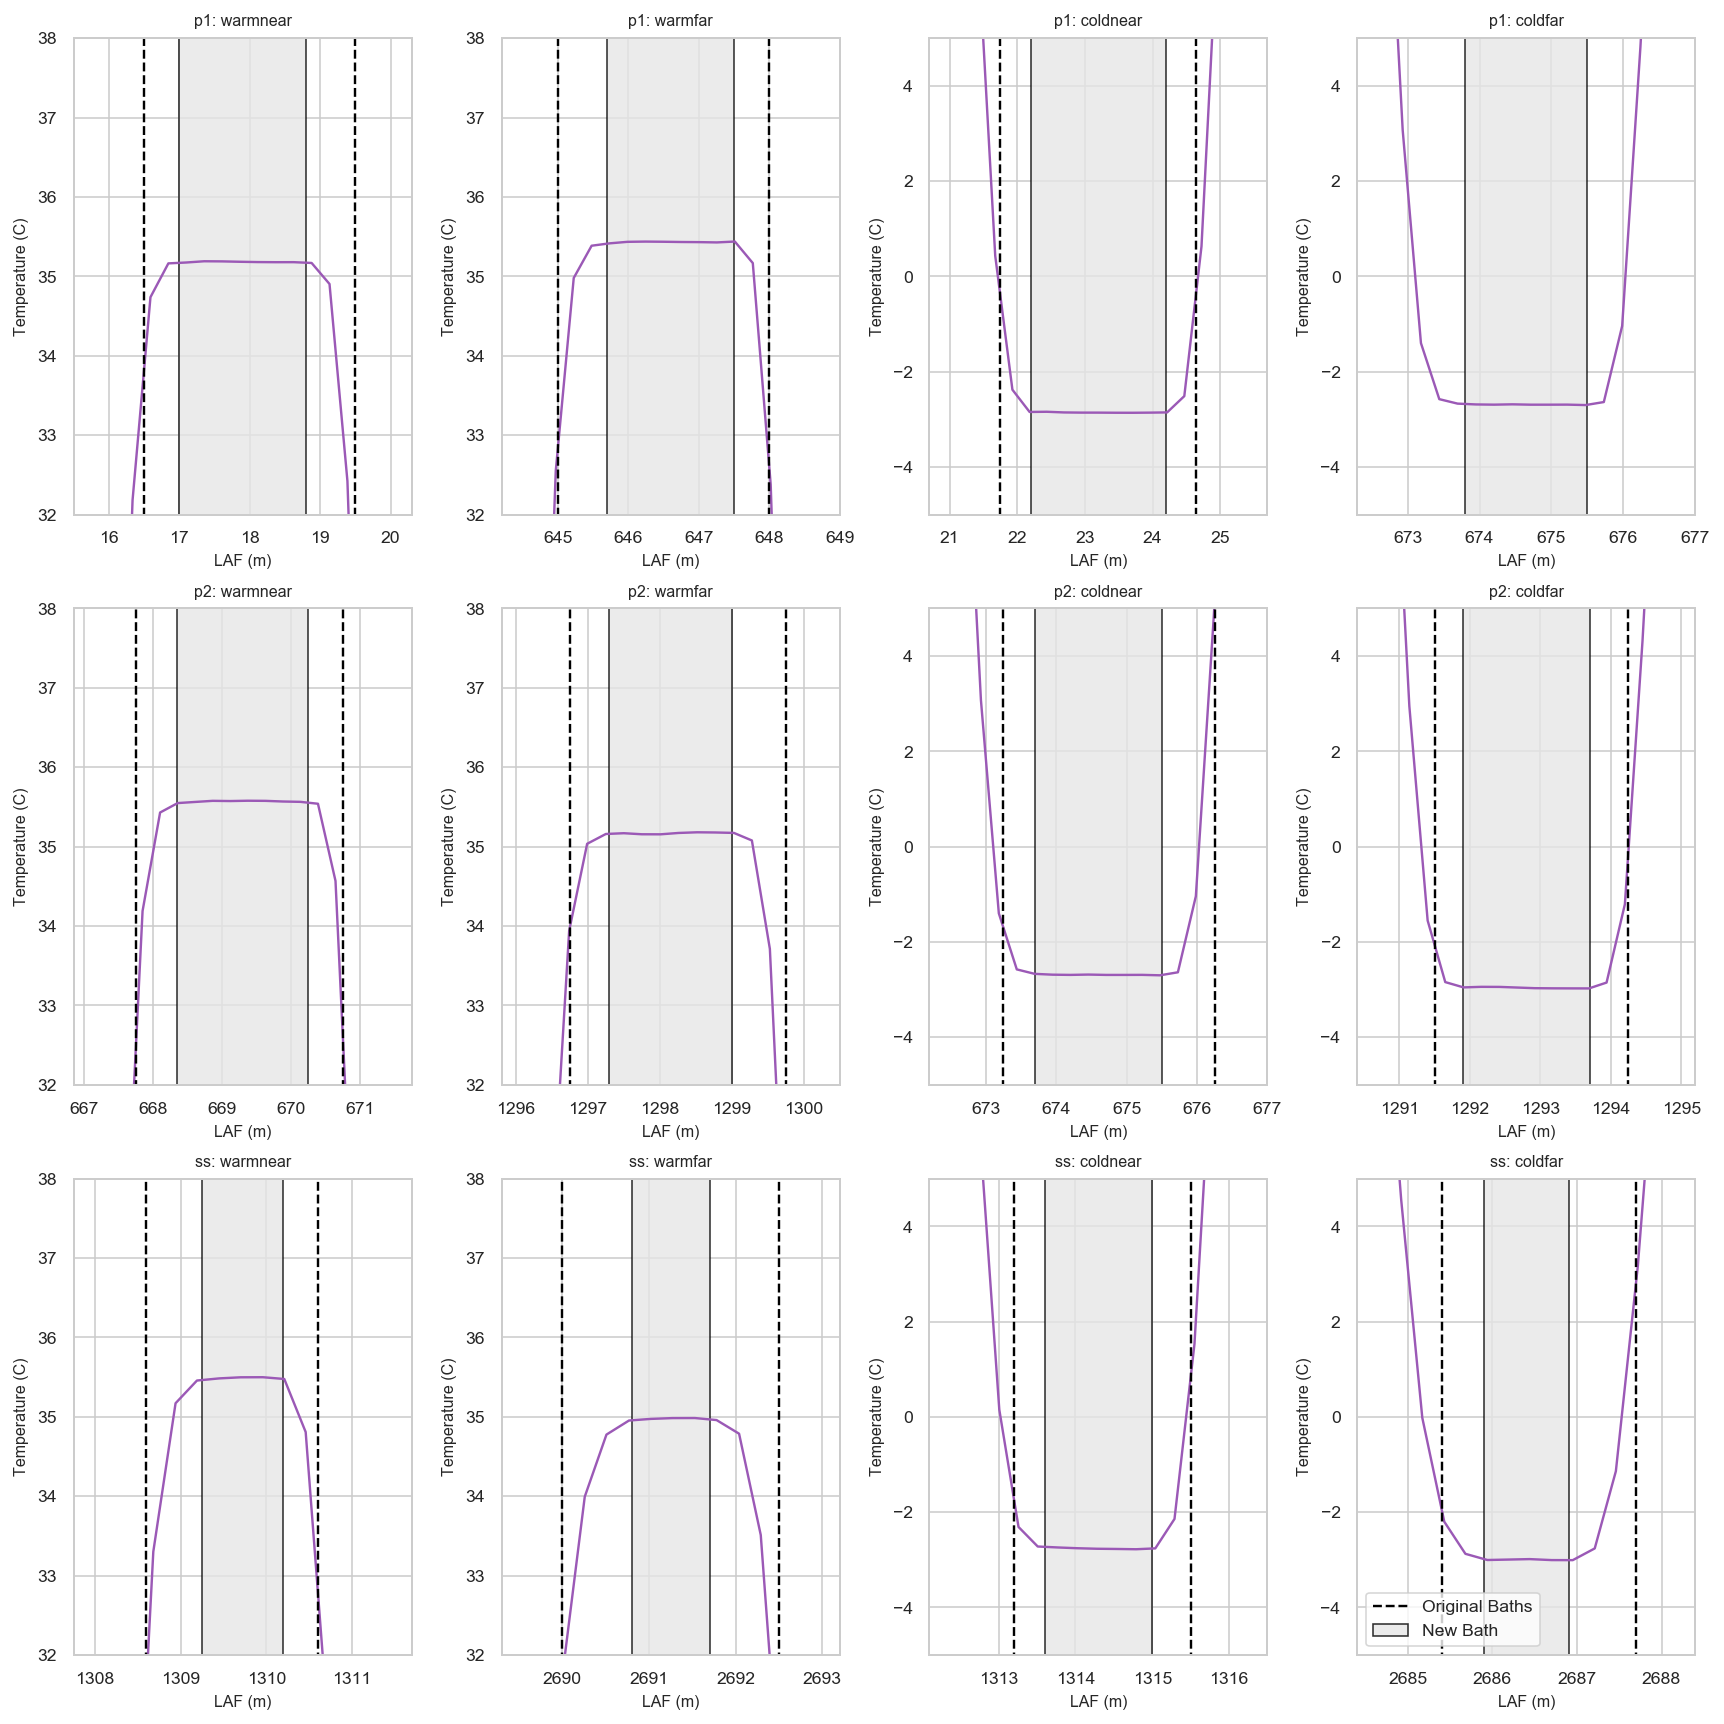

In [10]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for nc, c in enumerate(cores):
    for bn_num, bn in enumerate(bathnames):
        ax = axes[nc, bn_num]
        ax.set_title(c + ': ' + bn)
        
        bath_start = bath_locs_new[bn]['LAF'][c][0]
        bath_end = bath_locs_new[bn]['LAF'][c][1]
        
        # Fill in the "current" bath locations
        ax.fill_between([bath_start, bath_end], -20, 60, edgecolor='k', facecolor='0.9', alpha=0.8, label='New Bath')
        
        # The instrument reported temperature data
        ax.plot(dsraw.LAF, dsraw_mean.values)

        # The previous iteration of bath locations for comparison
        ax.plot([bath_locs_prev[bn]['LAF'][c][0], bath_locs_prev[bn]['LAF'][c][0]], [-20, 60], 'k--')
        ax.plot([bath_locs_prev[bn]['LAF'][c][1], bath_locs_prev[bn]['LAF'][c][1]], [-20, 60], 'k--', label='Original Baths')
        
        ax.set_xlim(bath_start - 1.5, bath_end + 1.5)
        
        if 'warm' in bn:
            ax.set_ylim(32, 38)
        elif 'cold' in bn:
            ax.set_ylim(-5, 5)
        ax.set_ylabel('Temperature (C)')
        ax.set_xlabel('LAF (m)')

ax.legend()
fig.tight_layout()


### $log(\frac{P_s}{P_as})$

Repeat the process with the power ratio

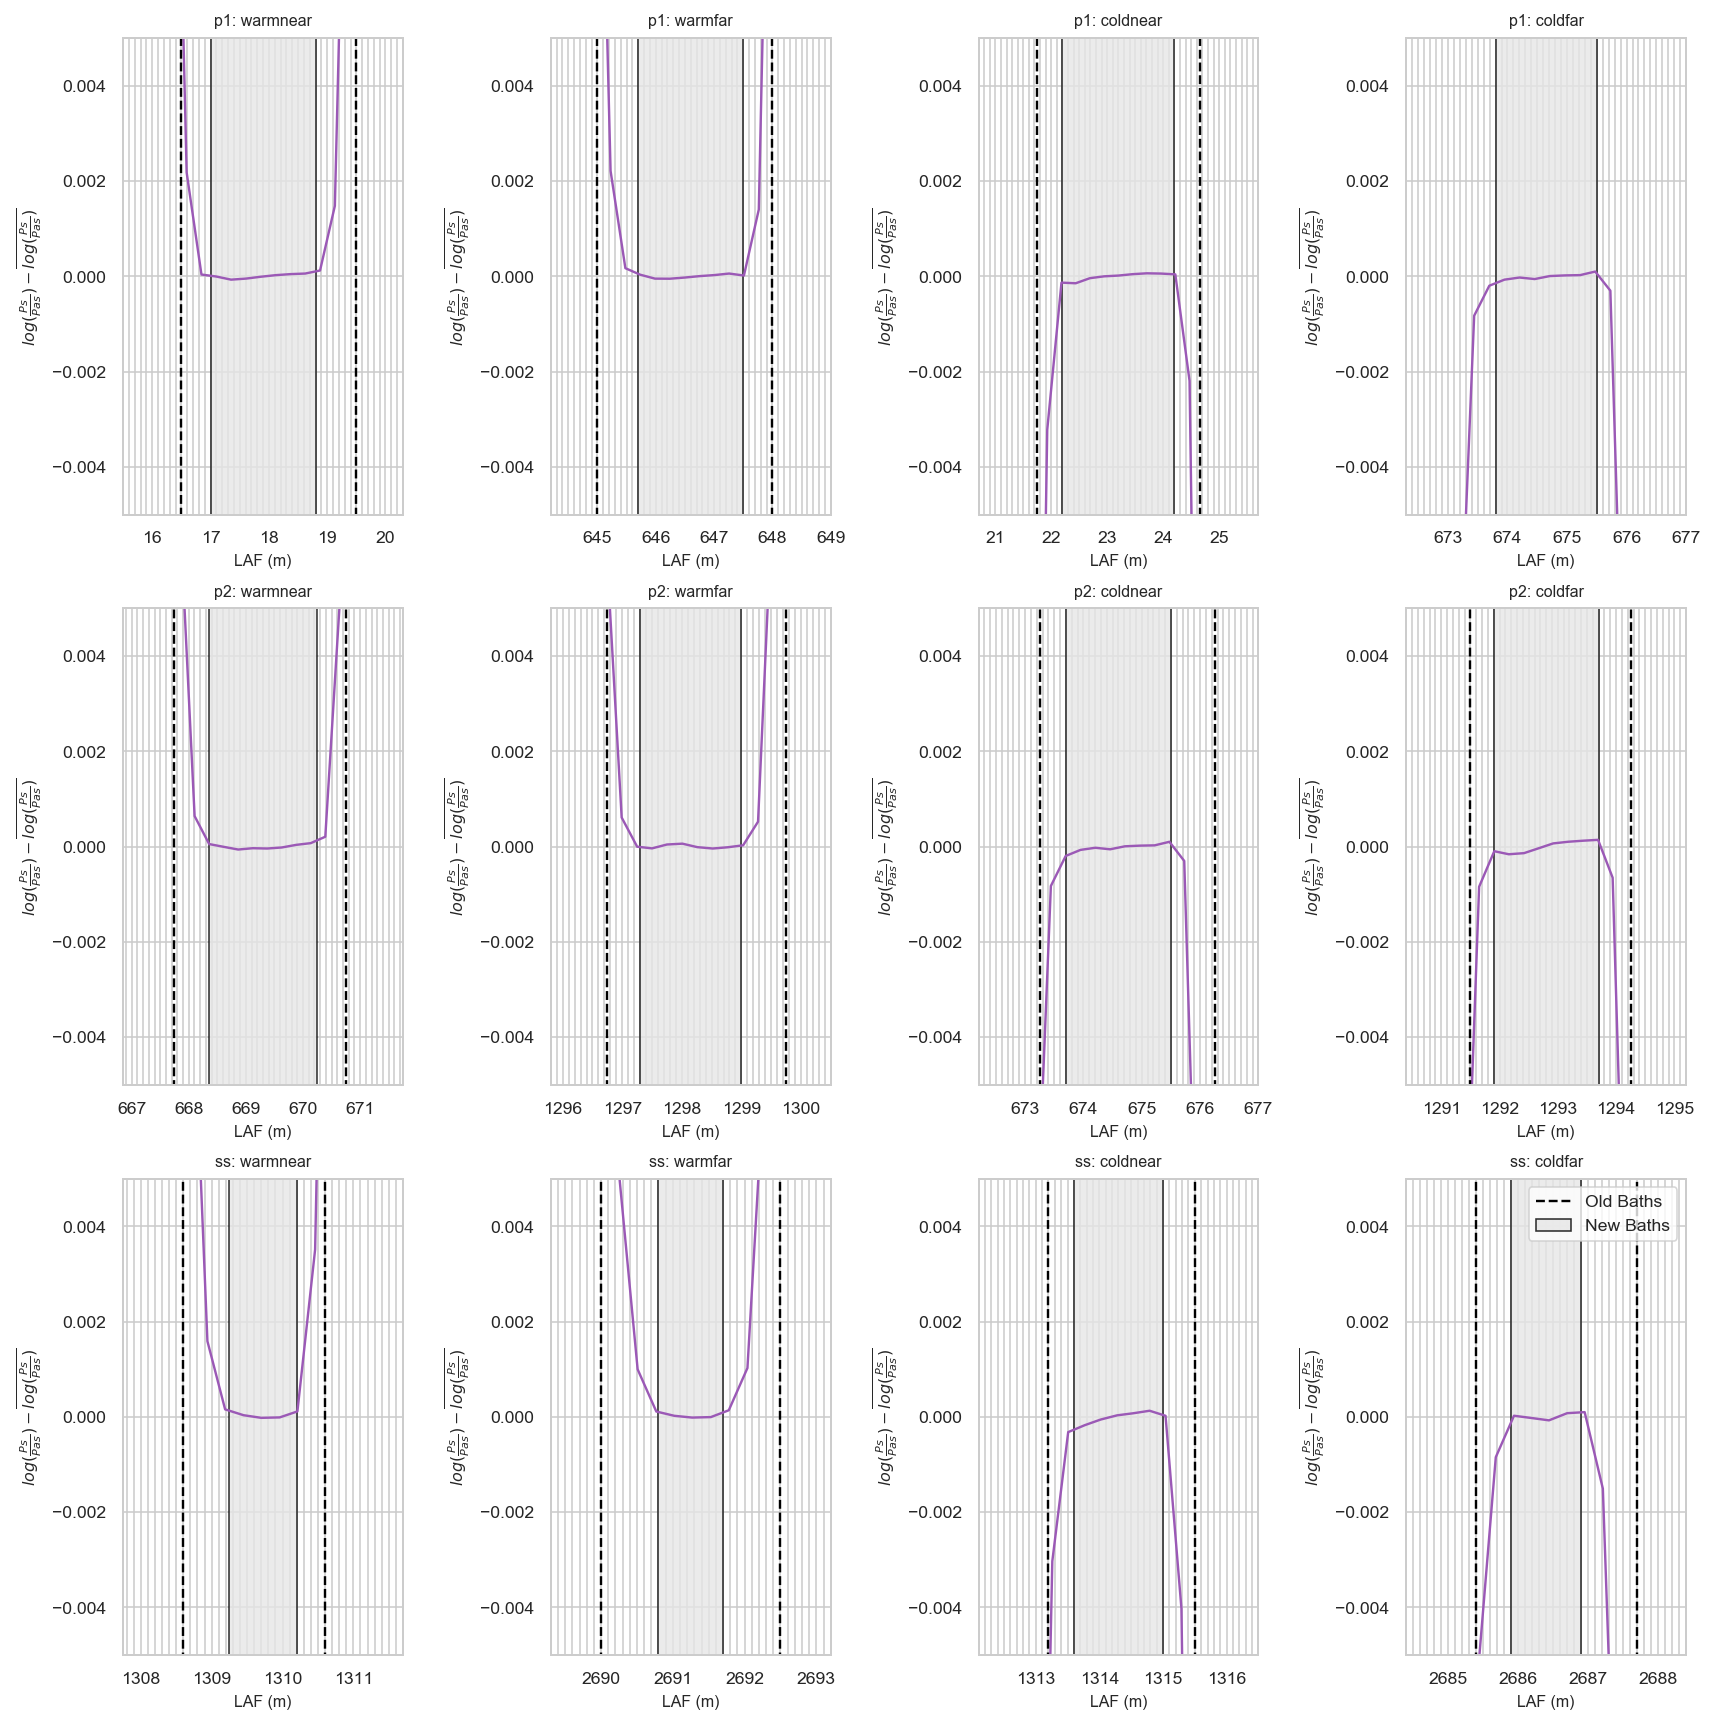

In [11]:
# Store the old (and incorrect) bath locations - v1

# ------------------------
# Mean of power
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for nc, c in enumerate(cores):
    for bn_num, bn in enumerate(bathnames):
        ax = axes[nc, bn_num]
        ax.xaxis.grid(True, which='minor')
        ax.set_title(c + ': ' + bn)

        bath_start = bath_locs_new[bn]['LAF'][c][0]
        bath_end = bath_locs_new[bn]['LAF'][c][1]
        mean_power = power.sel(LAF=slice(bath_start, bath_end)).mean(dim='LAF').mean(dim='time').values
        
        # Fill in the "current" bath locations
        ax.fill_between([bath_start, bath_end], -20, 60, edgecolor='k', facecolor='0.9', alpha=0.8, label='New Baths')

        # Power perturbation
        ax.plot(dsraw.LAF, power_timeavg.values - mean_power)

        # The previous iteration of bath locations for comparison
        ax.plot([bath_locs_prev[bn]['LAF'][c][0], bath_locs_prev[bn]['LAF'][c][0]], [-20, 60], 'k--', label='Old Baths')
        ax.plot([bath_locs_prev[bn]['LAF'][c][1], bath_locs_prev[bn]['LAF'][c][1]], [-20, 60], 'k--')
        
        ax.set_xlim(bath_start - 1.5, bath_end + 1.5)
        ax.set_ylim(-0.005, 0.005)

        ax.set_ylabel(r'$log(\frac{Ps}{Pas}) - \overline{log(\frac{Ps}{Pas})}$')
        ax.set_xlabel('LAF (m)')
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(.1))
ax.legend(loc='upper right', frameon=True)
fig.tight_layout()


## Standard deviation of log-power

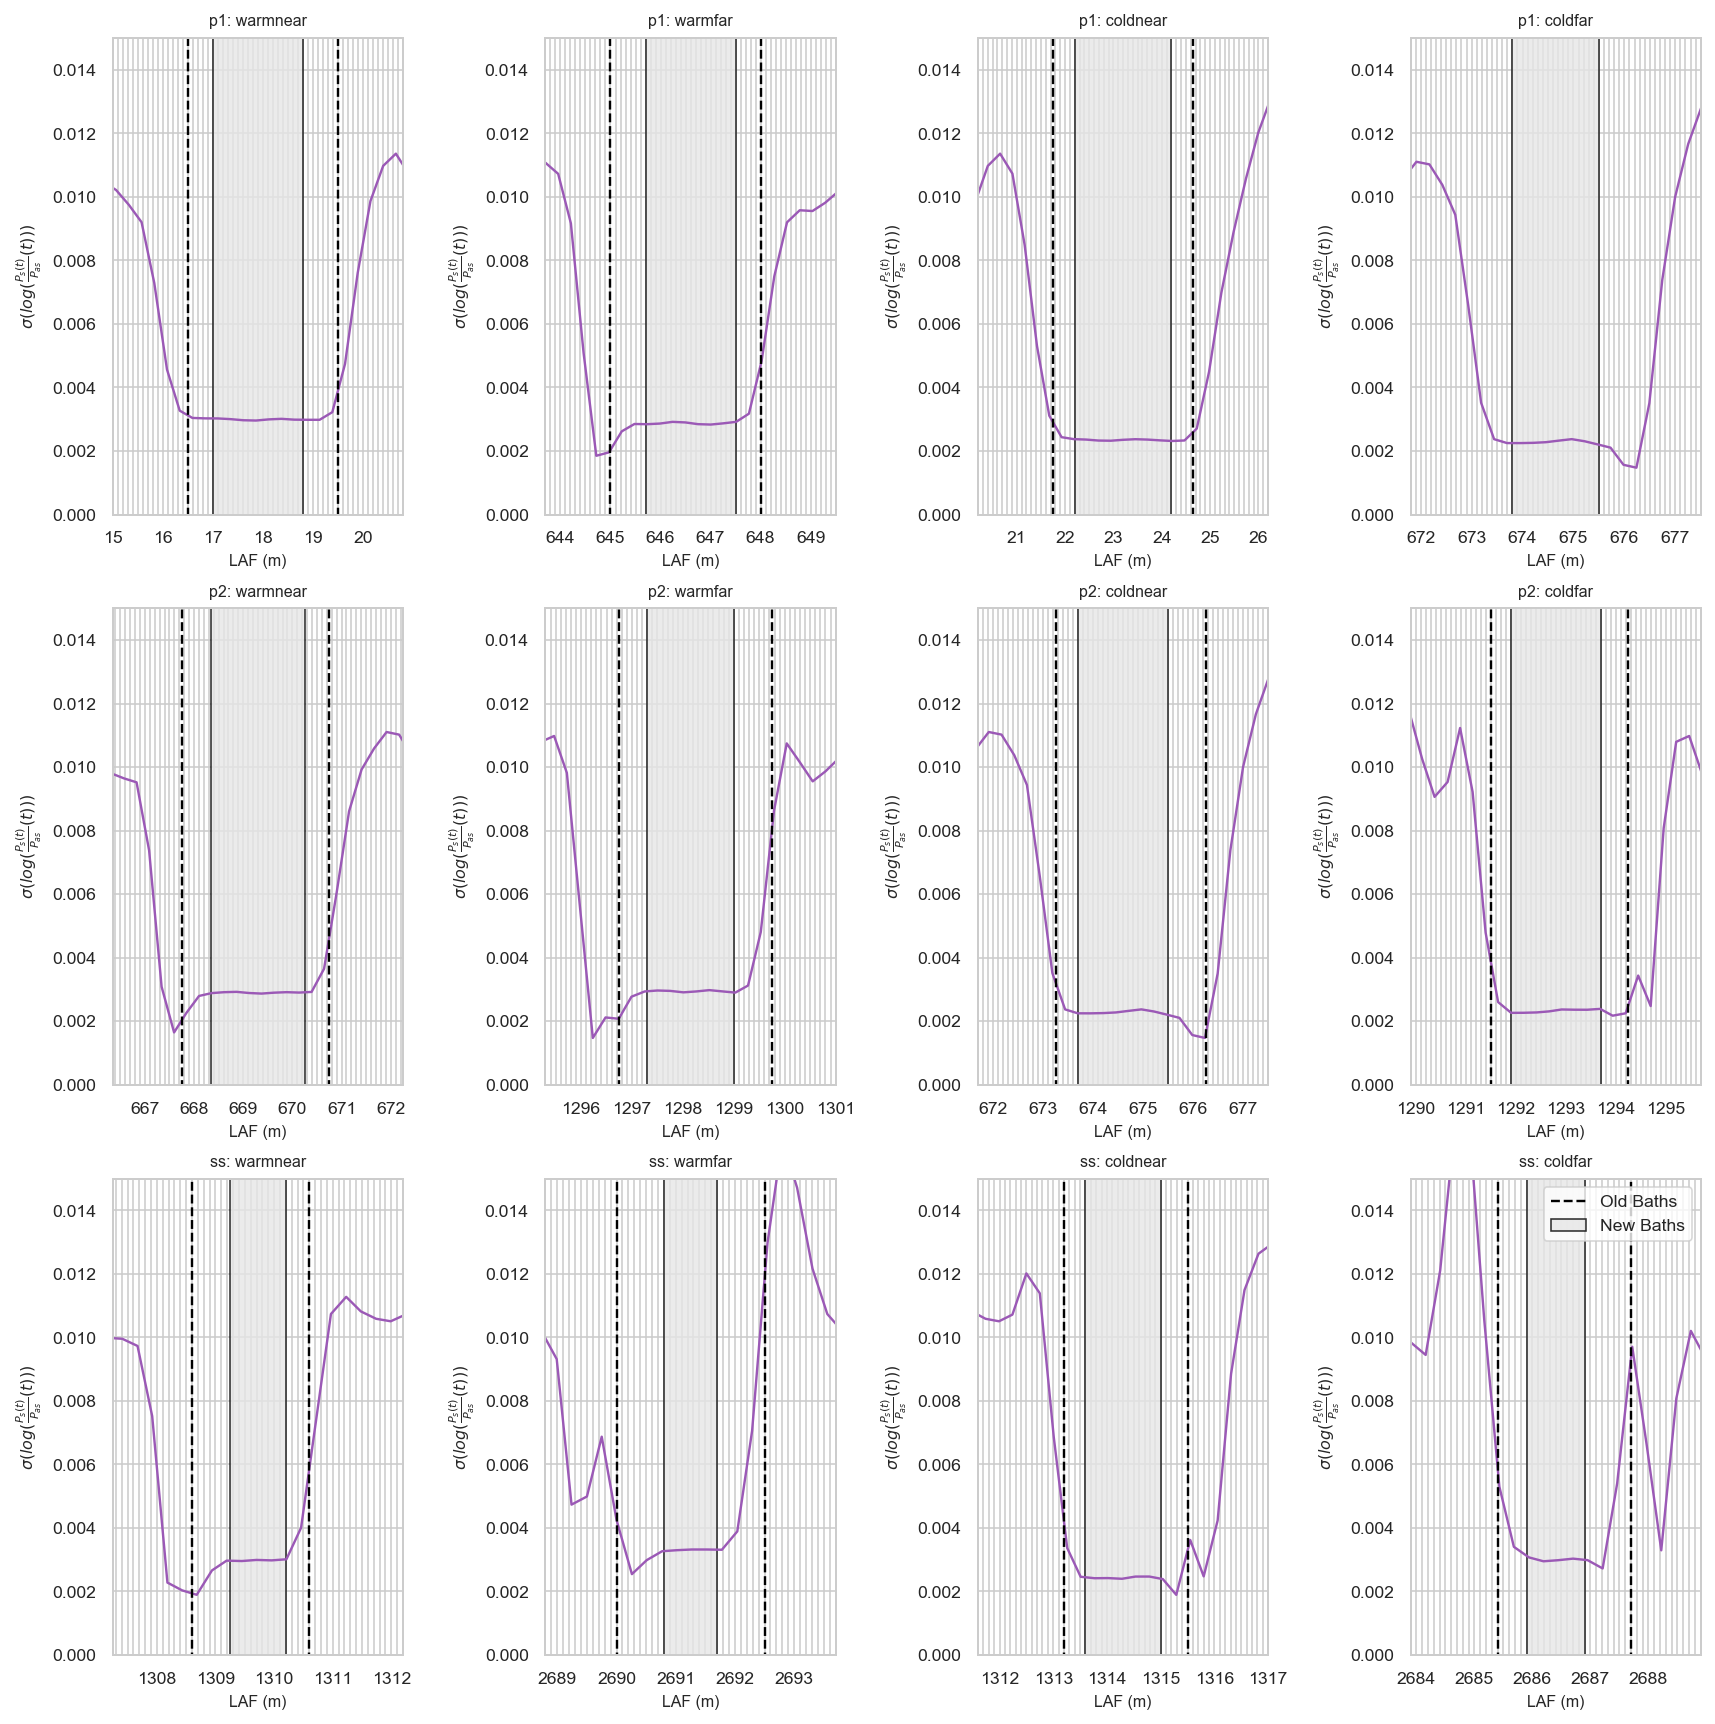

In [12]:
# ------------------------
# Standarad deviation of power
fig, axes = plt.subplots(3, 4, figsize=(12, 12))


for nc, c in enumerate(cores):
    for bn_num, bn in enumerate(bathnames):
        ax = axes[nc, bn_num]
        ax.xaxis.grid(True, which='minor')
        ax.set_title(c + ': ' + bn)

        bath_start = bath_locs_new[bn]['LAF'][c][0]
        bath_end = bath_locs_new[bn]['LAF'][c][1]
        
        # Fill in the "current" bath locations
        ax.fill_between([bath_start, bath_end], -20, 60, edgecolor='k', facecolor='0.9', alpha=0.8, label='New Baths')

        # The instrument reported temperature data
        ax.plot(dsraw.LAF, power_timestd.values)

        # The previous iteration of bath locations for comparison
        ax.plot([bath_locs_prev[bn]['LAF'][c][0], bath_locs_prev[bn]['LAF'][c][0]], [-20, 60], 'k--', label='Old Baths')
        ax.plot([bath_locs_prev[bn]['LAF'][c][1], bath_locs_prev[bn]['LAF'][c][1]], [-20, 60], 'k--')
        
        ax.set_xlim(bath_start - 2, bath_end + 2)
        ax.set_ylim(0, 0.015)

        ax.set_ylabel(r'$\sigma(log(\frac{P_s(t)}{P_{as}}(t)))$')
        ax.set_xlabel('LAF (m)')
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(.1))
ax.legend(loc='upper right', frameon=True)
fig.tight_layout()

### Spatial derivative of power

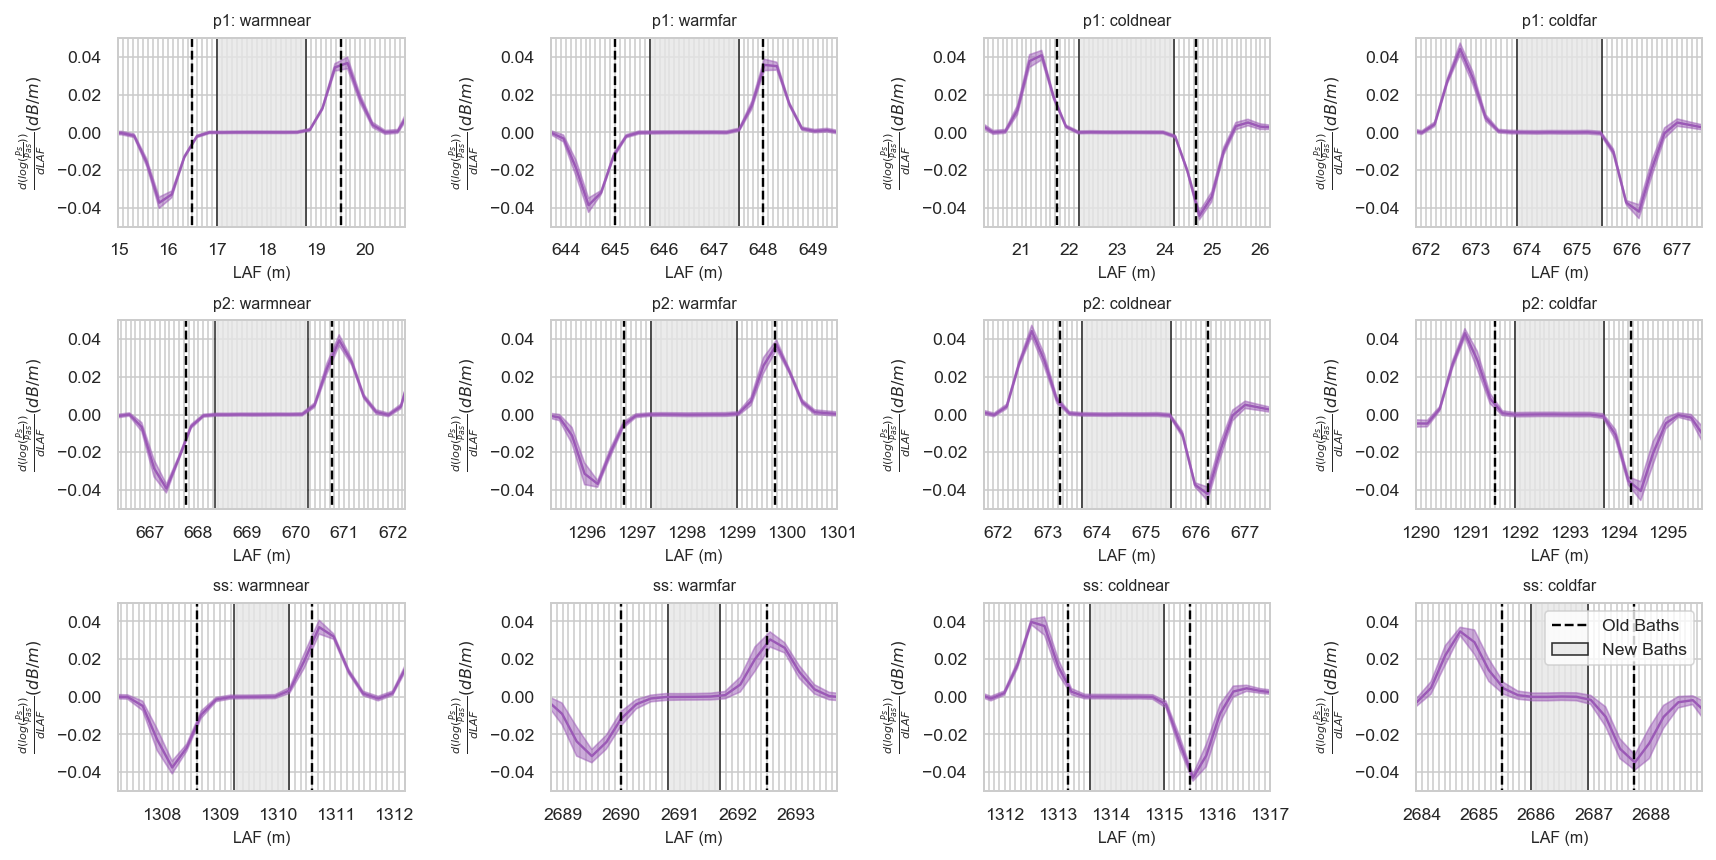

In [14]:
# ------------------------
# Standarad deviation of power
fig, axes = plt.subplots(3, 4, figsize=(12, 6))

# Derivative
dP_dLAF = power.diff(dim='LAF').mean(dim='time')
dP_dLAF_sigma = power.diff(dim='LAF').std(dim='time')

for nc, c in enumerate(cores):
    for bn_num, bn in enumerate(bathnames):
        ax = axes[nc, bn_num]
        ax.xaxis.grid(True, which='minor')
        ax.set_title(c + ': ' + bn)

        bath_start = bath_locs_new[bn]['LAF'][c][0]
        bath_end = bath_locs_new[bn]['LAF'][c][1]

        # Fill in the "current" bath locations
        ax.fill_between([bath_start, bath_end], -20, 60, edgecolor='k', facecolor='0.9', alpha=0.8, label='New Baths')

        # The instrument reported temperature data
        ax.plot(dsraw.LAF[0:-1], dP_dLAF.values)
        ax.fill_between(dsraw.LAF[0:-1].values, dP_dLAF - dP_dLAF_sigma, dP_dLAF + dP_dLAF_sigma, color=flatui[0], alpha=0.5)

        # The previous iteration of bath locations for comparison
        ax.plot([bath_locs_prev[bn]['LAF'][c][0], bath_locs_prev[bn]['LAF'][c][0]], [-20, 60], 'k--', label='Old Baths')
        ax.plot([bath_locs_prev[bn]['LAF'][c][1], bath_locs_prev[bn]['LAF'][c][1]], [-20, 60], 'k--')
        
        ax.set_xlim(bath_start - 2, bath_end + 2)
        ax.set_ylim(-0.05, 0.05)

        ax.set_ylabel(r'$\frac{d(log(\frac{Ps}{Pas}))}{dLAF} (dB/m)$')
        ax.set_xlabel('LAF (m)')
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(.1))
ax.legend(loc='upper right', frameon=True)
fig.tight_layout()

# Fiber status

## Spatial deviation in $log(\frac{P_s}{P_{as}})$

This quantity can highlight step-losses from breaks and other parts of the fiber that are behaving poorly. To do this we use the spatial standard deviation, which we here define as the standard deviation across ten spatial observations, in $P_s$ and $P_{as}$. Hausner 2016 states this is a good method for finding step losses. The stokes scattering is less senstive to temperature changes than the anti-stokes scattering. We use this behavior to find locations where the stokes scattering has more variability than the anti-stokes scattering, which may indicate a step loss.


In [24]:
import warnings
warnings.filterwarnings("ignore")

rolling_Ps = dsraw['Ps'].rolling(LAF=10, center=True).std().mean(dim='time')
rolling_Pas = dsraw['Pas'].rolling(LAF=10, center=True).std().mean(dim='time')
print(rolling_Ps)
print(rolling_Pas)
bad_ratio = (rolling_Ps > rolling_Pas).mean(dim='time')

<xarray.DataArray 'getitem-da3e622ef50a018aff781acee00bf301' (LAF: 11498)>
dask.array<shape=(11498,), dtype=float64, chunksize=(11498,)>
Coordinates:
  * LAF      (LAF) float64 -222.9 -222.6 -222.4 ... 2.699e+03 2.699e+03 2.7e+03
<xarray.DataArray 'getitem-1c0e5e3ca01e2c200ef7e76a721ffe42' (LAF: 11498)>
dask.array<shape=(11498,), dtype=float64, chunksize=(11498,)>
Coordinates:
  * LAF      (LAF) float64 -222.9 -222.6 -222.4 ... 2.699e+03 2.699e+03 2.7e+03


ValueError: 'time' not found in array dimensions ('LAF',)

Text(0, 0.5, '$\\sigma log(\\frac{P_s}{P_{as}})$')

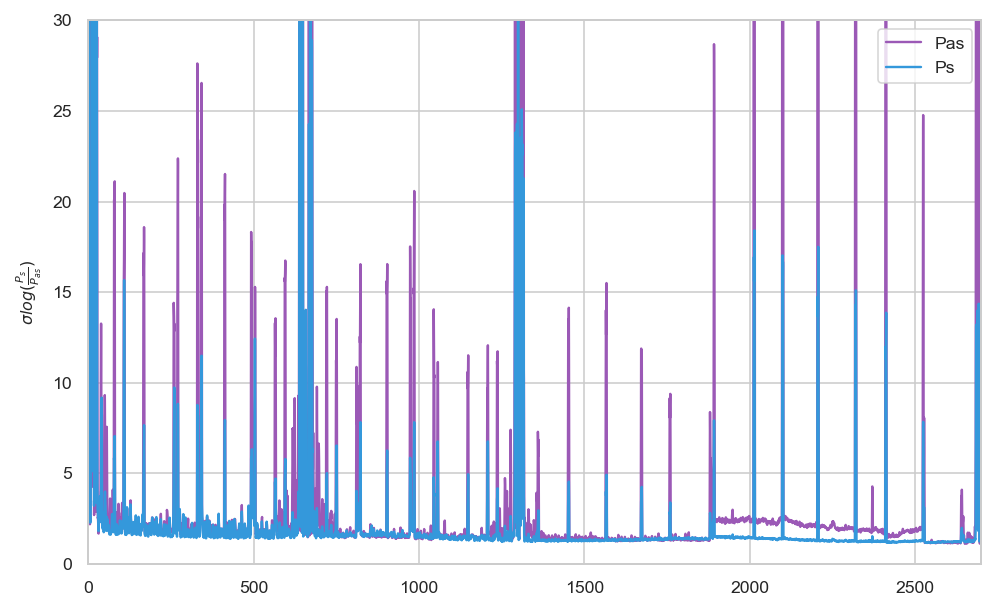

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rolling_Pas.LAF, rolling_Pas, label='Pas')
ax.plot(rolling_Ps.LAF, rolling_Ps, label='Ps')
ax.legend()
ax.set_ylim(0, 30)
ax.set_xlim(0, dsraw.LAF.max())
ax.set_ylabel(r'$\sigma log(\frac{P_s}{P_{as}})$')

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(bad_ratio.LAF, bad_ratio.values)
ax.set_ylabel(r'Fraction of time $\sigma(P_s(LAF)) > \sigma(P_{as}(LAF))$ [-]')
ax.set_xlim(0, 1800)
ax.set_ylim(0, 1)
ax.set_xlabel('LAF')